In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs
from kneed import KneeLocator

In [2]:
df = pd.read_csv("./customer_data.csv")

In [3]:
customer = df
customer.head(5)

,age,job,marital,education,default,housing,loan,comm_type,month,day_of_week,last_contact_duration,campaign_contact_count,poutcome,cons.price.idx,cons.conf.idx,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,nonexistent,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,nonexistent,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,nonexistent,93.994,-36.4,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,nonexistent,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,nonexistent,93.994,-36.4,5191.0


## Related to customer
1 - age (numeric)

2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

5 - default: has credit in default? (categorical: "no","yes","unknown")

6 - housing: has housing loan? (categorical: "no","yes","unknown")

7 - loan: has personal loan? (categorical: "no","yes","unknown")

## related with the last contact of the current campaign:

8 - comm_type: contact communication type (categorical: "cellular","telephone") 

9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

11 - last_contact_duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## other attributes(contact behaviour):

12 - campaign_contact_count: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

## social and economic context attributes

14 - cons.price.idx: consumer price index - monthly indicator (numeric)     

15 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     

16 - nr.employed: number of employees - quarterly indicator (numeric)

In [4]:
customer.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'comm_type', 'month', 'day_of_week', 'last_contact_duration',
       'campaign_contact_count', 'poutcome', 'cons.price.idx', 'cons.conf.idx',
       'nr.employed'],
      dtype='object')

## Details of each column

In [5]:
for i in customer.columns:
    print(i)
    print(customer[i].value_counts())
    print("\n--------------------------------------\n")

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
87       1
94       1
95       1
Name: age, Length: 78, dtype: int64

--------------------------------------

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

--------------------------------------

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

--------------------------------------

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

-------------------------------

## 'c_data' has names of column with categorical data

In [6]:
ind = []
l = customer.dtypes
for i in range(len(l)):
    if (str(l[i])=='object'):
        ind.append(i)
c_data = [customer.columns[i] for i in ind]
c_data

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'comm_type',
 'month',
 'day_of_week',
 'poutcome']

## dictionary 'd' stores column name as key and index as value. In K-prototype all columns should have numeric indices

In [7]:
d={}
k=0
for i in customer.columns:
    d[i]=k
    k=k+1
d

{'age': 0,
 'job': 1,
 'marital': 2,
 'education': 3,
 'default': 4,
 'housing': 5,
 'loan': 6,
 'comm_type': 7,
 'month': 8,
 'day_of_week': 9,
 'last_contact_duration': 10,
 'campaign_contact_count': 11,
 'poutcome': 12,
 'cons.price.idx': 13,
 'cons.conf.idx': 14,
 'nr.employed': 15}

## Renaming the columns

In [8]:
customer.rename(columns=d,inplace=True)

In [9]:
customer.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,nonexistent,93.994,-36.4,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,nonexistent,93.994,-36.4,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,nonexistent,93.994,-36.4,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,nonexistent,93.994,-36.4,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,nonexistent,93.994,-36.4,5191.0


In [21]:
c_list=[]
cluster_dict={}
for i in range(1,11):
    kproto = KPrototypes(n_clusters=i, init='Cao', verbose=2)
    clusters = kproto.fit_predict(customer, categorical=ind)
    cluster_dict[i]=clusters
    c_list.append(kproto.cost_)
    print("------------------------------------------------------")

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 99805.16700270932
Init: initial

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 1, ncost: 10157.271817885858
Run: 5, iteration: 2/100, moves: 0, ncost: 10157.271817885858
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 1, ncost: 12074.12851815679
Run: 6, iteration: 2/100, moves: 0, ncost: 12074.12851815679
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 9761.570100812794
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 0, ncost: 10459.760134417058
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 1, ncost: 10459.760134417058
Run: 9, iteration: 2/100, moves: 0, ncost: 10459.760134417058
Init: initializing centroids
Init: initializing cl

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
In

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Ini

ValueError: Clustering algorithm could not initialize. Consider assigning the initial clusters manually.

## Elbow Plot

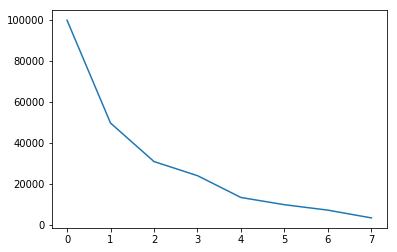

In [22]:
sns.lineplot(y=c_list,x=range(0,len(c_list)))

## Locating Elbow for adequate number of cluster

In [23]:
y=c_list
x = range(1, len(y)+1)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print("Number of clusters : ",kn.knee)

Number of clusters :  3


## Every cluster is stored in dictionary cd(starting from index 0). cd[n]=(n-1)th cluster

In [24]:
final_cluster = cluster_dict[kn.knee]
cd={}
for i in range(kn.knee):
    cd[i]=[]
    
for i in range(0,len(final_cluster)):
    cd[final_cluster[i]].append(list(customer.iloc[i]))

column = list(df.columns)
for i in range(len(cd)):
    cd[i]=pd.DataFrame(cd[i],columns=column)